In [44]:
%matplotlib inline
import numpy as np
import csv
import sys
import matplotlib.pyplot as plt

np.set_printoptions(edgeitems=10)

###Code for writing submission file

In [298]:
with open('data/test.txt') as csvfile:
    reader = csv.reader(csvfile)
    reader.next()
    with open ('submission.txt', 'w') as f:
        counter = 1
        f.write('Index,Count\n')
        for row in reader:
            f.write('{},{}\n'.format(counter, agg_round[(int(row[1])%10000)/100, int(row[0][1:])]))
            counter += 1

###Import data

In [439]:
data = np.loadtxt('data/train.txt', dtype=int, delimiter=',', skiprows=1)

###Fill data with row means

In [515]:
def fill(data, method='rowmean', roundtype='floor'):
    if method == 'rowmean':
        temp = data        
        for i in range(data.shape[0]):
            row_mean = temp[i, 1:][temp[i, 1:]!=-1].mean()
            if roundtype == 'ceil':
                row_mean = np.ceil(row_mean)
            elif roundtype == 'floor':
                row_mean = np.floor(row_mean)
            np.place(data[i], data[i]==-1, row_mean)
    
    return data

In [517]:
def fill_by_sensor(data, roundtype='floor'):
    temp = data        
    for i in range(data.shape[1]):
        if i > 0:
            hourmean = np.zeros(24)
            sensor = data[:, i][data[:, i] != -1]
            for i in range(24):
                hourmean[i] = sensor[i*1800:(i+1)*1800].mean()
            
        
        
#         row_mean = temp[i, 1:][temp[i, 1:]!=-1].mean()
#         if roundtype == 'ceil':
#             row_mean = np.ceil(row_mean)
#         elif roundtype == 'floor':
#             row_mean = np.floor(row_mean)
#         np.place(data[i], data[i]==-1, row_mean)
    
    return hourmean

In [518]:
fill_by_sensor(data)

array([ 0.10555556,  0.07666667,  0.035     ,  0.04388889,  0.10611111,
        0.165     ,  0.18722222,  0.04055556,  0.04444444,  0.13333333,
        0.165     ,  0.11222222,  0.08333333,  0.03055556,  0.075     ,
        0.11333333,  0.13222222,  0.15722222,  0.13944444,  0.03166667,
        0.14888889,  0.02388889,  0.15833333,  0.07888889])

In [267]:
a = fill(data, 'floor')
s = np.zeros((a.shape[0] / 60., a.shape[1]), dtype=int)

for i in range(s.shape[0]):
    s[i, 0] = a[(i+1)*60 - 1, 0] % 10000
    s[i, 1:] = np.sum(a[i*60:(i+1)*60, 1:], axis=0)

In [268]:
agg = np.zeros((24, a.shape[1]-1), dtype=int) # avg value for each sensor for each hour
for i in range(s.shape[0]):
    agg[(s[i, 0]-59) / 100] += s[i, 1:]
agg /= 30

###Adjacency List

In [191]:
with open('data/sensor-coordinates.txt') as f:
    coords = list()
    reader = csv.reader(f)
    reader.next()
    for row in reader:
        coords.append((float(row[1]), float(row[2])))

In [193]:
def dist(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [285]:
def get_nearest(coords, r=10):
    nearest = list()
    for i in range(56):
        temp = list()
        for j in range(56):
            if i != j:
                if dist(coords[i], coords[j]) < r:
                    temp.append(j+1)
        nearest.append((i+1, tuple(temp)))
    return nearest

In [286]:
n = get_nearest(coords)

In [294]:
def average(agg, p=2):
    temp_agg = np.array(agg, dtype=float)
    agg_f = np.array(agg, dtype=float)
    for i in range(agg_f.shape[1]):
        n_adj = len(n[i][1])
        agg_f[:, i] = p * temp_agg[:, i]
        for j in n[i][1]:
            agg_f[:, i] += temp_agg[:, j-1]
        agg_f[:, i] /= n_adj + p
    agg_round = np.round(agg_f)
    return agg_round

###GMM

In [3]:
from sklearn.gaussian_process import GaussianProcess

In [291]:
def timelist():
    t = list()
    for i in range(24):
        for j in range(60):
            t.append(100*i + j)
    return t

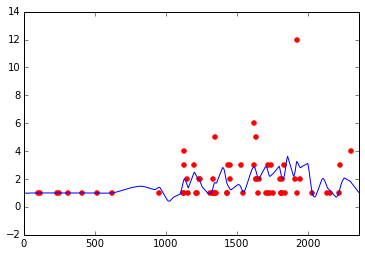

In [533]:
processes = list()
t = timelist()
n_ests = 2
for i in range(1):
    gps = [GaussianProcess(regr='quadratic', corr='cubic', theta0=1e-2, nugget=1e-10, normalize=True) for i in range(n_ests)]
    sensor = data[:, [0, i+1]]
    sensor = sensor[sensor[:, 1] > -1]
    sensor[:, 0] %= 10000
    for k in range(n_ests):
        X = list()
        y = list()
        trueX = list()
        truey = list()
        for j in t:
            filtered = sensor[sensor[:, 0] == j]
            if filtered.shape[0] != 0:
                choice = np.random.choice(np.arange(filtered.shape[0]))
                if filtered[choice, 1] == 0:
#                     if np.random.uniform() > 0.999:
#                         X.append(filtered[choice, 0])
#                         y.append(filtered[choice, 1])
                    pass
                else:
                    X.append(filtered[choice, 0])
                    y.append(filtered[choice, 1])
                trueX.append(filtered[choice, 0])
                truey.append(filtered[choice, 1])
                
        gps[k].fit(np.array(X).reshape(len(X), 1), np.array(y))

    t = timelist()
    resp = np.zeros((n_ests, len(t)))
    
    for j in range(n_ests):
        resp[j] = np.array([gps[j].predict(i)[0] for i in t])
    resp = resp.mean(axis=0)
    plt.plot(t, resp);
    plt.scatter(X, y, color='r');
    plt.xlim(0, 2359);

In [418]:
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import DistanceMetric

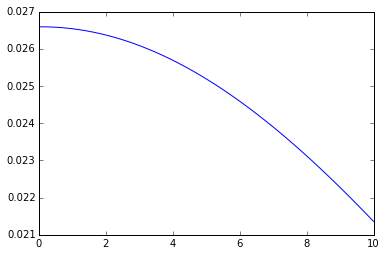

In [438]:
kd = KernelDensity(kernel='gaussian', bandwidth=15)
t = timelist()[900:950]
for i in [45]:
    sensor = data[:, [0, i+1]]
    sensor = sensor[sensor[:, 1] > -1]
    sensor[:, 0] %= 10000
    X = list()
    for i in range(10):
        for j in range(len(t)):
            filtered = sensor[sensor[:, 0] == t[j]]
            if filtered.shape[0] != 0:
                choice = np.random.choice(np.arange(filtered.shape[0]))
#                 if filtered[choice, 1] == 0:
#                     if np.random.uniform() > 0.99999999:
#                         X.append(filtered[choice, 1])
#                 else:
                X.append(filtered[choice, 1])

    kd.fit(np.array(X).reshape(len(X), 1))

kd.score_samples(1)
plt.plot(np.linspace(0,10), np.exp(kd.score_samples(np.linspace(0,10).reshape(50,1))))
# plt.scatter(, y, color='r');
# plt.xlim(0, 2359);

In [411]:
DistanceMetric.

[0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 2, 2, 1, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 2, 0, 4, 0, 0, 0, 2, 0, 0, 0, 1, 4, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 2, 8, 4, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 14, 3, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 4, 0, 0, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,

In [362]:
np.linspace(0, 3).shape

(50,)